In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy.random as npr
import re
from numba import jit
import scipy.stats
import scipy.special

In [5]:
def hpd(trace, mass_frac):
    d = np.sort(np.copy(trace))
    n = len(trace)
    n_samples = np.floor(mass_frac * n).astype(int)
    int_width = d[n_samples:] - d[:n-n_samples]
    min_int = np.argmin(int_width)
    return np.array([d[min_int], d[min_int+n_samples]])

# checking likelihood

In [318]:
import lm2
lm2 = reload(lm2)

In [306]:
np.log(lm2.convolve_binom_and_beta(0.4, 10, 0.4))

0.5290803673489011

In [307]:
lm2.log_convolve_binom_and_beta(0.4, 10, 0.4)

0.5290803673489011

In [308]:
lm2.log_convolve_binom_and_beta_mp(0.4, 10, 0.4)

0.5290803673489014

In [309]:
lm2.log_convolve_binom_and_beta(0.0, 10, 0.0)

0.0

In [317]:
np.log(lm2.convolve_binom_and_beta_sum(0.4, 10, 0.4))

/home/peter/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


0.5290803673489023

In [311]:
lm2.log_likelihood_model_B(sim_params, *model_args)

-38.95058494270367

In [314]:
lm2 = reload(lm2)
lm2.log_likelihood_model_B(sim_params, *model_args)

-38.95058494270367

In [319]:
lm2 = reload(lm2)
lm2.log_likelihood_model_B_alt(sim_params, *model_args)

-38.95058494270367

/home/peter/opt/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars


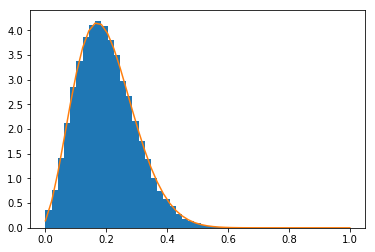

In [291]:
samp = 100000
n = 34
p = 0.2
b = npr.binomial(n, p, size=samp)
filt = (b > 0)&(b < n)
num_nonfixed = filt.sum()
x = np.zeros(samp)
x[filt] = npr.beta(b[filt], (n-b)[filt], size=num_nonfixed)
x[~filt] = b[~filt]/n
xplt = np.linspace(0, 1, 50)
y = np.array([lm2.convolve_binom_and_beta(xp, n, p) for xp in xplt])
plt.hist(x, bins=np.linspace(0, 1, 50), normed=True);
plt.gca().plot(xplt, y)

lm2.py:61: RuntimeWarning: divide by zero encountered in log
  #logprob = np.log(-n*(n-1)*(p-1)*p*((p-1)*(x-1))**(n-2)*scipy.special.hyp2f1(1-n, 2-n, 2, x*p/((x-1)*(p-1))))


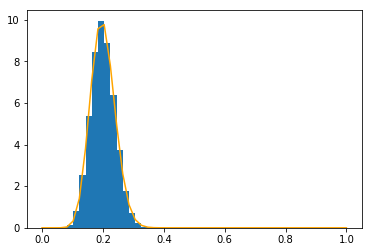

In [292]:
samp = 100000
n = 200
p = 0.2
b = npr.binomial(n, p, size=samp)
filt = (b > 0)&(b < n)
num_nonfixed = filt.sum()
x = np.zeros(samp)
x[filt] = npr.beta(b[filt], (n-b)[filt], size=num_nonfixed)
x[~filt] = b[~filt]/n
xplt = np.linspace(0, 1, 50)
y = np.array([np.exp(lm2.log_convolve_binom_and_beta(xp, n, p)) for xp in xplt])
plt.hist(x, bins=np.linspace(0, 1, 50), normed=True);
plt.gca().plot(xplt, y, color='orange')

# final results (discrete bottlenecks, uniform priors)

Results updated after Alison removed root frequencies from the data.

In [25]:
res_unif = pd.read_csv('results_uniform.txt', sep='\t', header=None, names=['ll', 'f', 'n1', 'n2'], skiprows=16, comment='#')
for col in ['n1', 'n2']:
    res_unif[col] = res_unif[col].astype(int)
frac_burnin = 0.2
burnin_idx = int(res_unif.shape[0]*frac_burnin+0.5)
res_unif = res_unif.iloc[burnin_idx:,:]
res_unif['frac_before'] = res_unif.eval('(1/n1)/(1/n1 + 1/n2)')

In [26]:
for col in ['f', 'n1', 'n2', 'frac_before']:
    print col, res_unif[col].median(), hpd(res_unif[col], 0.95)

f 0.475678109402 [0.03527099 0.86425183]
n1 27.0 [  9 123]
n2 11.0 [ 9 14]
frac_before 0.292682926829 [0.04954955 0.48275862]


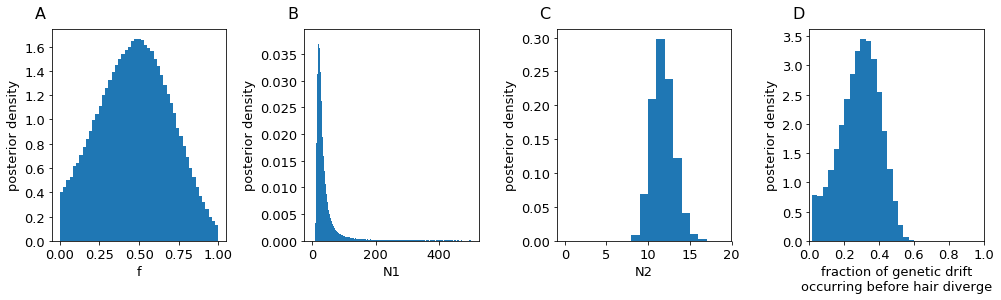

In [24]:
with mpl.rc_context({'font.size': 13}):
    f, axes = plt.subplots(1, 4, figsize=(14,4))

    res_unif['n1'] = res_unif['n1'].astype(int)
    res_unif['n2'] = res_unif['n2'].astype(int)

    res_unif['f'].plot.hist(bins=np.linspace(0,1,50), ax = axes[0], normed=True)
    res_unif['n1'].plot.hist(bins=np.arange(0, res_unif['n1'].max()+1), ax = axes[1], normed=True)
    res_unif['n2'].plot.hist(bins=np.arange(0, res_unif['n2'].max()+1), ax = axes[2], normed=True)
    res_unif['frac_before'].plot.hist(bins=20, ax = axes[3], normed=True)
    
    axes[0].set_xlabel('f')
    axes[1].set_xlabel('N1')
    axes[2].set_xlabel('N2')
    axes[3].set_xlabel('fraction of genetic drift\noccurring before hair diverge')
    axes[3].set_xlim((0,1))
    for ax in axes:
        ax.set_ylabel('posterior density')
with mpl.rc_context({'font.size': 16}):
    axes[0].text(-0.1, 1.05, 'A', transform=axes[0].transAxes)
    axes[1].text(-0.1, 1.05, 'B', transform=axes[1].transAxes)
    axes[2].text(-0.1, 1.05, 'C', transform=axes[2].transAxes)
    axes[3].text(-0.1, 1.05, 'D', transform=axes[3].transAxes)
f.tight_layout()
plt.savefig('figures/posterior_samples_combined.png', dpi=600, bbox_inches='tight')
plt.savefig('figures/posterior_samples_combined.pdf', dpi=600, bbox_inches='tight')